## 모듈 불러오기

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 성남시 지식산업센터 입주업체 현황(외부데이터) 불러오기

In [2]:
df_입주업체 = pd.read_excel("data/외부데이터/입주업체현황(지식)_홈페이지업로드용_202406.xlsx")

df_입주업체 = df_입주업체.dropna(subset=['연번'])
df_입주업체.head()

,회원여부,승계여부,연번,회 사 명,대표자,공장소재지,전화번호,주생산품
0,NaN,NaN,1.0,진우하이테크㈜,조현섭,"성남시 중원구 사기막골로 99, 성남센트럴비즈타워2차 B동 1112호",02-0511-0374,유량계 등 계측장비
1,NaN,NaN,2.0,㈜대양씨아이에스,최동성,성남시 중원구 상대원동 5445 우림라이온스밸리3차 512호,02-1544-1745,무인키오스크
2,NaN,NaN,3.0,㈜그이름,정준호,"성남시 중원구 상대원동 442-13 중일아인스프라츠3차 301,302,303",02-1800-3033,"참기름, 떡"
3,NaN,NaN,4.0,㈜제이플레이,문재희,"성남시 중원구 갈마치로 314, 성남센트럴비즈타워 1101",02-1800-5950,켱영컨설팅
4,NaN,NaN,5.0,㈜퍼스텍아이앤씨,선상규,"성남시 중원구 상대원동 146-8 우림라이온스밸리2차 A동 B318,B319,B32...",02-2026-4820,디지털도어락


In [3]:
df_지식산업센터 = pd.read_csv("data/원천데이터/7.성남시_지식산업센터.csv", encoding="utf-8")
df_지식산업센터.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gbn            56 non-null     object 
 1   klg_ids_ct_nm  56 non-null     object 
 2   lon            56 non-null     float64
 3   lat            56 non-null     float64
 4   addr           56 non-null     object 
 5   rd_addr        56 non-null     object 
 6   useapr_day     56 non-null     object 
 7   use_area       56 non-null     object 
 8   arch_area      56 non-null     int64  
 9   tot_cpn        51 non-null     float64
 10  cpn_in_2101    41 non-null     float64
 11  cpn_in_2201    43 non-null     float64
 12  cpn_in_2302    47 non-null     float64
 13  cpn_in_2402    50 non-null     float64
 14  cpn_in_2406    49 non-null     float64
 15  rmrk           10 non-null     object 
dtypes: float64(8), int64(1), object(7)
memory usage: 7.1+ KB


## 지식산업센터 입주업체별 사용 호실수 확인

In [4]:
# --- 주소 정규화 함수 ---
def normalize_address(addr):
    """
    addr에서 띄어쓰기를 제거하고,
    "경기도" 접두어를 제거한 후, 
    "성남시" 뒤에 나오는 구(예, "중원구", "분당구" 등)를 삭제하여
    "성남시"까지만 남기도록 합니다.
    """
    if not isinstance(addr, str):
        return addr
    addr = addr.replace(" ", "")
    addr = re.sub(r"^경기도", "", addr)         # "경기도" 접두어 제거
    # "성남시" 뒤에 나오는 구를 제거 (예: "성남시중원구" -> "성남시")
    addr = re.sub(r'(성남시)[가-힣]+구', r'\1', addr)
    return addr

# --- 1. 전처리 ---
# df_지식산업센터: addr, rd_addr, klg_ids_ct_nm 전처리 (띄어쓰기 제거 및 정규화)
for col in ["addr", "rd_addr"]:
    df_지식산업센터[col] = df_지식산업센터[col].apply(normalize_address)
# klg_ids_ct_nm도 띄어쓰기 제거 (필요 시 추가 정규화 가능)
df_지식산업센터["klg_ids_ct_nm"] = df_지식산업센터["klg_ids_ct_nm"].str.replace(" ", "")

# df_입주업체: 공장소재지 전처리 (띄어쓰기 제거 및 정규화)
df_입주업체["공장소재지"] = df_입주업체["공장소재지"].apply(normalize_address)

# --- 2. 호실 수를 계산하는 함수 정의 ---
def count_units_from_token(token):
    """
    토큰 내에서 숫자로 시작하는 부분을 찾아서,
    만약 '~' 또는 '-'가 있으면 범위로 인식하여 호실 개수를 계산합니다.
    (예, "305~312" 또는 "311-313"이면 범위 내의 호실 개수를 계산)
    단, '-'의 경우 왼쪽과 오른쪽 숫자의 자릿수가 다르면 단일 토큰(1개)으로 계산합니다.
    
    추가로, 토큰 내에 건물명을 나타내는 "V1" 문자열은 제거합니다.
    """
    token = token.replace("V1", "")  # "V1" 제거
    m = re.search(r'(\d.*)', token)
    if not m:
        return 0
    s = m.group(1)
    m_range = re.search(r'(\d+)\s*(?:~|-)\s*(\d+)', s)
    if m_range:
        left, right = m_range.group(1), m_range.group(2)
        if len(left) != len(right):
            return 1
        else:
            return int(right) - int(left) + 1
    else:
        return 1

def count_units_simple(unit_str):
    """
    unit_str (예: "B동1112", "305~312,316,317", "311-313,315.317" 등)을 받아서,
    콤마(,)나 점(.)을 구분자로 분리한 각 토큰별로 count_units_from_token()을 적용하여
    총 호실 수를 계산합니다.
    """
    unit_str = unit_str.rstrip('호')
    tokens = re.split(r'[,\.]', unit_str)
    total = 0
    for token in tokens:
        token = token.strip()
        if token:
            total += count_units_from_token(token)
    return total

# --- 3. 주소(기본주소 및 klg_ids_ct_nm) 기준으로 호실수 추출 함수 ---
def extract_unit_count_based_on_address(address, base_addresses, klg_names):
    """
    - address: df_입주업체의 "공장소재지"
         예) "성남시순환로165포스테크노B106" 또는
             "성남시사기막골로105번길25중앙인더스피아2차603-1,603-2" 또는
             "성남시...SK센트럴..." 등
    - base_addresses: df_지식산업센터의 기본주소 목록 (normalize_address를 적용한 addr, rd_addr)
    - klg_names: df_지식산업센터의 klg_ids_ct_nm 목록
    
    처리 순서:
      1) address의 시작부분이 base_addresses 중 하나로 시작하면,
         그 부분(기본주소)을 제거한 나머지(remainder)를 대상으로 호실 수 계산.
      2) 만약 (1)에 해당하지 않으면, klg_names 중 하나가 address 내에 포함되어 있으면,
         그 위치 이후의 부분을 대상으로 호실 수 계산.
      3) 해당하는 것이 없으면 0을 반환.
      
    예외 처리:
      - address에 "608606~608"와 같은 문제 패턴이 있으면 예외로 7를 반환.
      
    추가: 만약 기본주소 또는 klg_ids_ct_nm 이후의 remainder에 숫자가 전혀 없으면 1을 반환.
    """
    if not isinstance(address, str):
        return 0

    if "608606~608" in address:
        return 7

    # 1) 기본주소 기준 처리
    for base in base_addresses:
        if address.startswith(base):
            remainder = address[len(base):].lstrip(',').strip()
            if not re.search(r'\d', remainder):
                return 1
            m = re.search(r'([A-Za-z0-9가-힣,~\-\.]+)호$', remainder)
            if m:
                unit_info = m.group(1)
                return count_units_simple(unit_info)
            else:
                return count_units_simple(remainder)
    
    # 2) klg_ids_ct_nm 기준 처리
    for name in klg_names:
        if name in address:
            idx = address.find(name)
            remainder = address[idx + len(name):].lstrip(',').strip()
            if not re.search(r'\d', remainder):
                return 1
            m = re.search(r'([A-Za-z0-9가-힣,~\-\.]+)호$', remainder)
            if m:
                unit_info = m.group(1)
                return count_units_simple(unit_info)
            else:
                return count_units_simple(remainder)
    
    return 0

# --- 4. 기본주소 및 klg_ids_ct_nm 목록 생성 ---
base_addresses = pd.concat([
    df_지식산업센터["addr"],
    df_지식산업센터["rd_addr"]
]).dropna().unique()

klg_names = df_지식산업센터["klg_ids_ct_nm"].dropna().unique()

# --- 5. df_입주업체에 '호실수' 칼럼 추가 ---
df_입주업체["호실수"] = df_입주업체["공장소재지"].apply(
    lambda addr: extract_unit_count_based_on_address(addr, base_addresses, klg_names)
)

# --- 6. 결과 확인 ---
print(df_입주업체.head(10))

  회원여부 승계여부    연번     회   사   명  대표자  \
0  NaN  NaN   1.0       진우하이테크㈜  조현섭   
1  NaN  NaN   2.0      ㈜대양씨아이에스  최동성   
2  NaN  NaN   3.0          ㈜그이름  정준호   
3  NaN  NaN   4.0        ㈜제이플레이  문재희   
4  NaN  NaN   5.0      ㈜퍼스텍아이앤씨  선상규   
5  NaN  NaN   6.0        블루카이트㈜  이광우   
6  NaN  NaN   7.0      ㈜탭스푸드서비스  배윤성   
7  NaN  NaN   8.0      ㈜탭스인터내셔널  배윤성   
8  NaN  NaN   9.0      뉴라인데코Div  김대경   
9  NaN  NaN  10.0  후지인스트루먼트코리아㈜  이종배   

                                          공장소재지          전화번호        주생산품  호실수  
0                 성남시사기막골로99,성남센트럴비즈타워2차B동1112호  02-0511-0374  유량계 등 계측장비    1  
1                     성남시상대원동5445우림라이온스밸리3차512호  02-1544-1745      무인키오스크    1  
2            성남시상대원동442-13중일아인스프라츠3차301,302,303  02-1800-3033      참기름, 떡    3  
3                      성남시갈마치로314,성남센트럴비즈타워1101  02-1800-5950       켱영컨설팅    1  
4  성남시상대원동146-8우림라이온스밸리2차A동B318,B319,B320,B321호  02-2026-4820      디지털도어락    4  
5                성남시상대원동144-1중앙인더스피아3차B207,B112  02-2038-4208      LED 조명

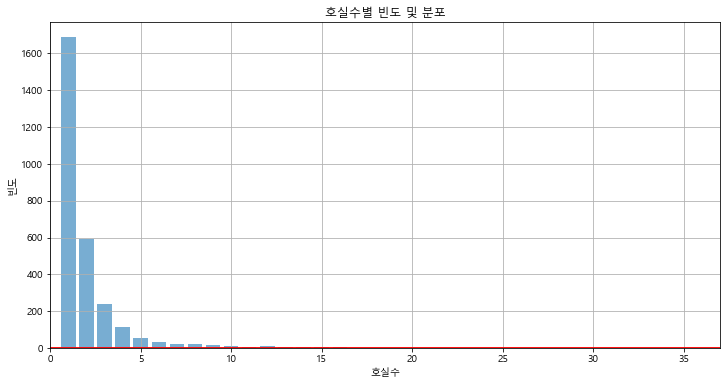

In [5]:
# 한글 폰트 설정 (Windows의 경우)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 그래프 크기 설정 
plt.figure(figsize=(12, 6))

# 호실수별 빈도수 계산
value_counts = df_입주업체['호실수'].value_counts().sort_index()

# 바 플롯 그리기
plt.bar(value_counts.index, value_counts.values, alpha=0.6)

# KDE 플롯 추가
sns.kdeplot(data=df_입주업체['호실수'], color='red', linewidth=2)

plt.title("호실수별 빈도 및 분포")
plt.xlabel("호실수")
plt.ylabel("빈도")
plt.xlim(0, 37)
plt.grid(True)
plt.show()

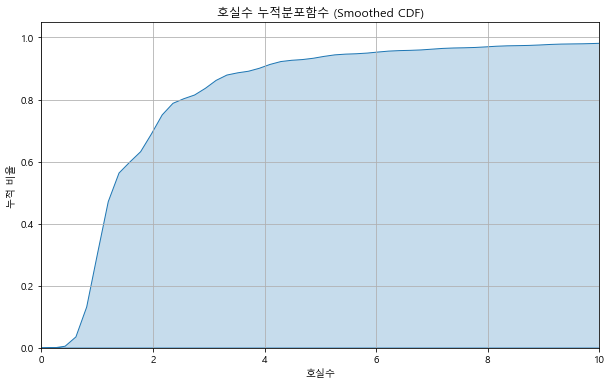

In [6]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_입주업체, x="호실수", cumulative=True, bw_adjust=0.5, fill=True)
plt.title("호실수 누적분포함수 (Smoothed CDF)")
plt.xlabel("호실수")
plt.ylabel("누적 비율")
plt.xlim(0, 10)
plt.grid(True)
plt.show()

In [7]:
df_입주업체.to_csv("data/전처리데이터/성남시_입주업체_호실수포함.csv", encoding="utf-8")

## 지식산업센터별 사용 호실수 확인

In [8]:
# 1. df_지식산업센터에 center_id (고유 식별자) 추가
df_지식산업센터 = df_지식산업센터.reset_index().rename(columns={"index": "center_id"})

# --- 새롭게 추가한: center 이름 분리 함수 ---
def split_center_name(name):
    """
    예: "중앙인더스피아1차" -> ("중앙인더스피아", 1)
        "중앙인더스피아" -> ("중앙인더스피아", None)
    """
    m = re.match(r'^(.*?)(\d+)차$', name)
    if m:
        base = m.group(1)
        number = int(m.group(2))
        return base, number
    else:
        return name, None

# --- 2. df_입주업체에 center_id 할당을 위한 함수 정의 (매칭 조건 수정)
def assign_center_id(address, centers):
    """
    - address: df_입주업체의 전처리된 "공장소재지"
    - centers: df_지식산업센터 DataFrame (전처리된 addr, rd_addr, klg_ids_ct_nm 포함)
    
    로직:
      1) centers의 각 행에 대해, addr 또는 rd_addr로 시작하면 해당 센터의 center_id 할당.
      2) 그렇지 않으면, klg_ids_ct_nm 기준으로 매칭:
           - 만약 센터명이 숫자(차수) 없이 "중앙인더스피아"처럼 되어 있다면,
             주소 내에서 center_base 뒤에 바로 숫자와 "차"가 붙지 않은 경우에만 매칭.
           - 만약 센터명이 "중앙인더스피아1차" 또는 "중앙인더스피아2차"처럼 되어 있다면,
             주소 내에 정확히 center_base + 해당 숫자 + "차"가 있는 경우에만 매칭.
      3) 모두 해당되지 않으면 None 반환.
    
    참고: 모든 문자열은 전처리 시 공백이 제거된 상태입니다.
    """
    if not isinstance(address, str):
        return None
    for _, row in centers.iterrows():
        # ① 기본주소 기준: addr 또는 rd_addr로 시작하면 바로 반환
        base_candidates = [row['addr'], row['rd_addr']]
        if any(address.startswith(base) for base in base_candidates):
            return row['center_id']
        
        # ② klg_ids_ct_nm 기준
        center_name = row['klg_ids_ct_nm']
        center_base, center_number = split_center_name(center_name)
        if center_number is None:
            # 센터명이 "중앙인더스피아"처럼 숫자가 없는 경우:
            # 주소 내에서 center_base가 있고, 그 뒤에 바로 숫자와 "차"가 이어지지 않아야 함.
            pattern = re.escape(center_base) + r'(?!\d+차)'
        else:
            # 센터명이 "중앙인더스피아1차", "중앙인더스피아2차" 등인 경우:
            # 주소 내에 정확히 center_base + 숫자 + "차"가 있어야 함.
            pattern = re.escape(center_base) + str(center_number) + r'차'
        
        if re.search(pattern, address):
            return row['center_id']
    return None


# 3. df_입주업체에 center_id 컬럼 추가
df_입주업체['center_id'] = df_입주업체['공장소재지'].apply(lambda addr: assign_center_id(addr, df_지식산업센터))

# 4. center_id별 호실수 합계 계산
grouped_units = df_입주업체.groupby('center_id')['호실수'].sum().reset_index()

# 5. df_지식산업센터와 병합하여 총 호실수를 추가 (매칭되지 않는 센터는 0 처리)
df_지식산업센터 = pd.merge(df_지식산업센터, grouped_units, on='center_id', how='left')
df_지식산업센터['호실수'] = df_지식산업센터['호실수'].fillna(0)

print(df_지식산업센터.head())

   center_id       gbn klg_ids_ct_nm         lon        lat         addr  \
0          0        개별       분당테크노파크  127.151000  37.405505    성남시야탑동145   
1          1        개별       분당남서울첨단  127.101041  37.378855  성남시백현동404-1   
2          2        개별       반도아이비밸리  127.093969  37.427271    성남시고등동603   
3          3        개별  현대지식산업센터성남고등  127.093677  37.428911    성남시고등동572   
4          4  도시첨단산업단지      LH기업성장센터  127.093952  37.411578  성남시시흥동294-2   

                    rd_addr useapr_day use_area  arch_area  tot_cpn  \
0  성남시판교로697(700)(723)(744)   1994.09.     근린상업     193217    866.0   
1            성남시대왕판교로395번길8   2001.11.     자연녹지      10496      NaN   
2                성남시청계산로686   2020.02.     근린상업      41544    320.0   
3                   성남시고등로3   2021.01.    준주거지역      49915    342.0   
4                  성남시창업로54   2018.05.    준공업지역      53053    246.0   

   cpn_in_2101  cpn_in_2201  cpn_in_2302  cpn_in_2402  cpn_in_2406  \
0        423.0        423.0        533.0      

In [9]:
df_입주업체.head()

,회원여부,승계여부,연번,회 사 명,대표자,공장소재지,전화번호,주생산품,호실수,center_id
0,NaN,NaN,1.0,진우하이테크㈜,조현섭,"성남시사기막골로99,성남센트럴비즈타워2차B동1112호",02-0511-0374,유량계 등 계측장비,1,50.0
1,NaN,NaN,2.0,㈜대양씨아이에스,최동성,성남시상대원동5445우림라이온스밸리3차512호,02-1544-1745,무인키오스크,1,35.0
2,NaN,NaN,3.0,㈜그이름,정준호,"성남시상대원동442-13중일아인스프라츠3차301,302,303",02-1800-3033,"참기름, 떡",3,38.0
3,NaN,NaN,4.0,㈜제이플레이,문재희,"성남시갈마치로314,성남센트럴비즈타워1101",02-1800-5950,켱영컨설팅,1,46.0
4,NaN,NaN,5.0,㈜퍼스텍아이앤씨,선상규,"성남시상대원동146-8우림라이온스밸리2차A동B318,B319,B320,B321호",02-2026-4820,디지털도어락,4,42.0


In [10]:
# --- 7. 총호실수 및 공실률 계산 ---

def calculate_total_units(row):
    """
    row: DataFrame의 한 행 (Series)
    만약 '호실수'가 'tot_cpn'보다 크면 'cpn_in_2406'을 선택하고,
    그렇지 않으면 '호실수'와 'cpn_in_2406' 중 더 큰 값을 선택합니다.
    """
    return max(row['호실수'], row['cpn_in_2406'])

df_지식산업센터['총호실수'] = df_지식산업센터.apply(calculate_total_units, axis=1)

# "공실률": (tot_cpn - 총호실수) / tot_cpn  
df_지식산업센터['공실률'] = (df_지식산업센터['tot_cpn'] - df_지식산업센터['총호실수']) / df_지식산업센터['tot_cpn']

print("\n[최종 결과 - 총호실수 및 공실률 추가] df_지식산업센터 head:")
print(df_지식산업센터.head())



[최종 결과 - 총호실수 및 공실률 추가] df_지식산업센터 head:
   center_id       gbn klg_ids_ct_nm         lon        lat         addr  \
0          0        개별       분당테크노파크  127.151000  37.405505    성남시야탑동145   
1          1        개별       분당남서울첨단  127.101041  37.378855  성남시백현동404-1   
2          2        개별       반도아이비밸리  127.093969  37.427271    성남시고등동603   
3          3        개별  현대지식산업센터성남고등  127.093677  37.428911    성남시고등동572   
4          4  도시첨단산업단지      LH기업성장센터  127.093952  37.411578  성남시시흥동294-2   

                    rd_addr useapr_day use_area  arch_area  tot_cpn  \
0  성남시판교로697(700)(723)(744)   1994.09.     근린상업     193217    866.0   
1            성남시대왕판교로395번길8   2001.11.     자연녹지      10496      NaN   
2                성남시청계산로686   2020.02.     근린상업      41544    320.0   
3                   성남시고등로3   2021.01.    준주거지역      49915    342.0   
4                  성남시창업로54   2018.05.    준공업지역      53053    246.0   

   cpn_in_2101  cpn_in_2201  cpn_in_2302  cpn_in_2402  cpn_in_2406  \
0    

In [11]:
df_지식산업센터

,center_id,gbn,klg_ids_ct_nm,lon,lat,addr,rd_addr,useapr_day,use_area,arch_area,tot_cpn,cpn_in_2101,cpn_in_2201,cpn_in_2302,cpn_in_2402,cpn_in_2406,rmrk,호실수,총호실수,공실률
0,0,개별,분당테크노파크,127.151000,37.405505,성남시야탑동145,성남시판교로697(700)(723)(744),1994.09.,근린상업,193217,866.0,423.0,423.0,533.0,138.0,139.0,2024.02 / 2024.06 입주업체수는 공장등록 업체수만 해당됨,0.0,139.0,0.839492
1,1,개별,분당남서울첨단,127.101041,37.378855,성남시백현동404-1,성남시대왕판교로395번길8,2001.11.,자연녹지,10496,NaN,6.0,6.0,4.0,1.0,1.0,2024.02 / 2024.06 입주업체수는 공장등록 업체수만 해당됨,0.0,1.0,NaN
2,2,개별,반도아이비밸리,127.093969,37.427271,성남시고등동603,성남시청계산로686,2020.02.,근린상업,41544,320.0,152.0,152.0,210.0,13.0,14.0,2024.02 / 2024.06 입주업체수는 공장등록 업체수만 해당됨,0.0,14.0,0.956250
3,3,개별,현대지식산업센터성남고등,127.093677,37.428911,성남시고등동572,성남시고등로3,2021.01.,준주거지역,49915,342.0,NaN,NaN,263.0,13.0,13.0,2024.02 / 2024.06 입주업체수는 공장등록 업체수만 해당됨,0.0,13.0,0.961988
4,4,도시첨단산업단지,LH기업성장센터,127.093952,37.411578,성남시시흥동294-2,성남시창업로54,2018.05.,준공업지역,53053,246.0,114.0,114.0,118.0,120.0,114.0,NaN,0.0,114.0,0.536585
5,5,도시첨단산업단지,경기기업성장센터,127.094469,37.412121,성남시시흥동293,성남시창업로42,2019.01.,준공업지역,70628,355.0,135.0,135.0,113.0,117.0,121.0,NaN,0.0,121.0,0.659155
6,6,도시첨단산업단지,판교이노베이션랩,127.085360,37.406059,성남시금토동411-6,성남시금토로80번길11,2022.01.,준주거지역,25170,168.0,NaN,NaN,21.0,22.0,22.0,NaN,0.0,22.0,0.869048
7,7,도시첨단산업단지,성남글로벌융합센터,127.095061,37.409049,성남시시흥동356,성남시달래내로46,2022.03.,준공업지역,36617,78.0,NaN,NaN,13.0,12.0,12.0,NaN,0.0,12.0,0.846154
8,8,도시첨단산업단지,글로벌Biz센터,127.096007,37.411792,성남시시흥동293외8필지,수정구창업로43,2023.03.,복합용지+준주거지역,95588,254.0,NaN,NaN,NaN,48.0,44.0,NaN,0.0,44.0,0.826772
9,9,도시첨단산업단지,판교IT센터,127.092743,37.411934,판교제2테크노밸리E2-1,성남시창업로40번길30,2023.06.,준공업지역,38359,259.0,NaN,NaN,NaN,13.0,19.0,NaN,0.0,19.0,0.926641


In [12]:
# center_id가 15인 행들만 선택
subset = df_입주업체[df_입주업체['center_id'] == 13
                ]

# 결과 확인 (예: 상위 5개 행 출력)
subset


,회원여부,승계여부,연번,회 사 명,대표자,공장소재지,전화번호,주생산품,호실수,center_id
172,NaN,NaN,173.0,라벨컴,박광진,성남시상대원동517-13중앙인더스피아1차407호,02-574-7019,"라벨, 스티커",1,13.0
279,NaN,NaN,280.0,㈜스킨셀랩,강명구,"성남시둔촌대로449,중앙인더스피아1차302호",031-602-4660,기초화장품,1,13.0
339,NaN,NaN,340.0,㈜브이엠테크,박경한,"성남시둔촌대로449,중앙인더스피아1차303호",031-625-2725,핸드폰무인충전기,1,13.0
570,NaN,NaN,571.0,㈜타치온네트웍스제2공장,유병문,성남시상대원동517-13중앙인더스피아1차711,031-730-0077,무선통신기기,1,13.0
617,NaN,NaN,618.0,화인정보,김석훈,성남시상대원동517-13중앙인더스피아1차406호,031-731-5945,"라벨, 스티커",1,13.0
661,NaN,NaN,662.0,발레리제,박경열,"성남시상대원동517-13중앙인더스피아1차408,311,211",031-732-3799,수제 초콜렛,3,13.0
671,NaN,NaN,672.0,㈜에이치브이피,김원호,성남시상대원동517-13중앙인더스피아1차605,031-732-6550,전원공급장치,1,13.0
691,NaN,NaN,692.0,㈜스위브,최형석,"성남시둔촌대로449,중앙인더스피아1차B104호",031-733-1881,전동모빌리티용급속충전기,1,13.0
729,NaN,NaN,730.0,하얀산업㈜,손해동,"성남시사기막골로105번길25,중앙인더스피아902호",031-734-2611,주방자동소화장치,1,13.0
734,NaN,NaN,735.0,㈜그린디바이스,여범준,성남시상대원동517-13중앙인더스피아1차504~507호,031-734-3454,통신단말기,4,13.0


In [13]:
df_지식산업센터

,center_id,gbn,klg_ids_ct_nm,lon,lat,addr,rd_addr,useapr_day,use_area,arch_area,tot_cpn,cpn_in_2101,cpn_in_2201,cpn_in_2302,cpn_in_2402,cpn_in_2406,rmrk,호실수,총호실수,공실률
0,0,개별,분당테크노파크,127.151000,37.405505,성남시야탑동145,성남시판교로697(700)(723)(744),1994.09.,근린상업,193217,866.0,423.0,423.0,533.0,138.0,139.0,2024.02 / 2024.06 입주업체수는 공장등록 업체수만 해당됨,0.0,139.0,0.839492
1,1,개별,분당남서울첨단,127.101041,37.378855,성남시백현동404-1,성남시대왕판교로395번길8,2001.11.,자연녹지,10496,NaN,6.0,6.0,4.0,1.0,1.0,2024.02 / 2024.06 입주업체수는 공장등록 업체수만 해당됨,0.0,1.0,NaN
2,2,개별,반도아이비밸리,127.093969,37.427271,성남시고등동603,성남시청계산로686,2020.02.,근린상업,41544,320.0,152.0,152.0,210.0,13.0,14.0,2024.02 / 2024.06 입주업체수는 공장등록 업체수만 해당됨,0.0,14.0,0.956250
3,3,개별,현대지식산업센터성남고등,127.093677,37.428911,성남시고등동572,성남시고등로3,2021.01.,준주거지역,49915,342.0,NaN,NaN,263.0,13.0,13.0,2024.02 / 2024.06 입주업체수는 공장등록 업체수만 해당됨,0.0,13.0,0.961988
4,4,도시첨단산업단지,LH기업성장센터,127.093952,37.411578,성남시시흥동294-2,성남시창업로54,2018.05.,준공업지역,53053,246.0,114.0,114.0,118.0,120.0,114.0,NaN,0.0,114.0,0.536585
5,5,도시첨단산업단지,경기기업성장센터,127.094469,37.412121,성남시시흥동293,성남시창업로42,2019.01.,준공업지역,70628,355.0,135.0,135.0,113.0,117.0,121.0,NaN,0.0,121.0,0.659155
6,6,도시첨단산업단지,판교이노베이션랩,127.085360,37.406059,성남시금토동411-6,성남시금토로80번길11,2022.01.,준주거지역,25170,168.0,NaN,NaN,21.0,22.0,22.0,NaN,0.0,22.0,0.869048
7,7,도시첨단산업단지,성남글로벌융합센터,127.095061,37.409049,성남시시흥동356,성남시달래내로46,2022.03.,준공업지역,36617,78.0,NaN,NaN,13.0,12.0,12.0,NaN,0.0,12.0,0.846154
8,8,도시첨단산업단지,글로벌Biz센터,127.096007,37.411792,성남시시흥동293외8필지,수정구창업로43,2023.03.,복합용지+준주거지역,95588,254.0,NaN,NaN,NaN,48.0,44.0,NaN,0.0,44.0,0.826772
9,9,도시첨단산업단지,판교IT센터,127.092743,37.411934,판교제2테크노밸리E2-1,성남시창업로40번길30,2023.06.,준공업지역,38359,259.0,NaN,NaN,NaN,13.0,19.0,NaN,0.0,19.0,0.926641


In [14]:
# "호실수"가 0이 아닌 행만 선택하여 다시 저장합니다.
# df_지식산업센터 = df_지식산업센터[df_지식산업센터["호실수"] != 0].copy()

# 1. "useapr_day"의 앞 4글자가 모두 숫자인 행만 남기기
mask = df_지식산업센터["useapr_day"].str[:4].str.isdigit()
df_지식산업센터 = df_지식산업센터[mask].copy()

# 2. 앞 4글자를 정수형으로 변환하여 "year" 컬럼 생성
df_지식산업센터["year"] = df_지식산업센터["useapr_day"].str[:4].astype(int)

# 3. 앞 4글자를 정수형으로 변환하여 "year" 컬럼 생성
df_지식산업센터 = df_지식산업센터[df_지식산업센터["year"] < 2022]


# 결과 확인
print(df_지식산업센터.head())

   center_id       gbn klg_ids_ct_nm         lon        lat         addr  \
0          0        개별       분당테크노파크  127.151000  37.405505    성남시야탑동145   
1          1        개별       분당남서울첨단  127.101041  37.378855  성남시백현동404-1   
2          2        개별       반도아이비밸리  127.093969  37.427271    성남시고등동603   
3          3        개별  현대지식산업센터성남고등  127.093677  37.428911    성남시고등동572   
4          4  도시첨단산업단지      LH기업성장센터  127.093952  37.411578  성남시시흥동294-2   

                    rd_addr useapr_day use_area  arch_area  ...  cpn_in_2101  \
0  성남시판교로697(700)(723)(744)   1994.09.     근린상업     193217  ...        423.0   
1            성남시대왕판교로395번길8   2001.11.     자연녹지      10496  ...          6.0   
2                성남시청계산로686   2020.02.     근린상업      41544  ...        152.0   
3                   성남시고등로3   2021.01.    준주거지역      49915  ...          NaN   
4                  성남시창업로54   2018.05.    준공업지역      53053  ...        114.0   

   cpn_in_2201  cpn_in_2302  cpn_in_2402  cpn_in_2406  \
0    

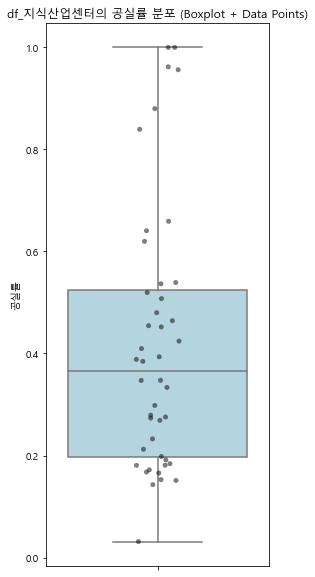

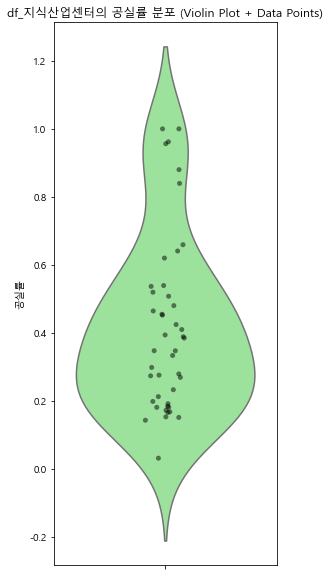

In [15]:
# --- Horizontal Boxplot (y축에 공실률) + 데이터 포인트 ---
plt.figure(figsize=(4,10))
sns.boxplot(y=df_지식산업센터['공실률'], color='lightblue')
sns.stripplot(y=df_지식산업센터['공실률'], color='black', alpha=0.5)
plt.ylabel("공실률")
plt.title("df_지식산업센터의 공실률 분포 (Boxplot + Data Points)")
plt.show()

# --- Horizontal Violin Plot (y축에 공실률) + 데이터 포인트 ---
plt.figure(figsize=(4, 10))
sns.violinplot(y=df_지식산업센터['공실률'], inner=None, color='lightgreen')
sns.stripplot(y=df_지식산업센터['공실률'], color='black', alpha=0.5)
plt.ylabel("공실률")
plt.title("df_지식산업센터의 공실률 분포 (Violin Plot + Data Points)")
plt.show()

In [16]:
df_지식산업센터.to_csv("data/전처리데이터/성남시_지식산업센터_공실률포함.csv", encoding="utf-8")